### Running through entire dataset using test mode
We'll do this to evaluate the success of the ESM-BLSTM model (that we utilized transfer learning on using original DMS data) on new DMS data.

In [1]:
#!/usr/bin/env python
"""
Model runner for ESM model fed into BLSTM, where ESM embeddings get updated.
"""

import os
import re
import sys
import math
import tqdm
import torch
import time
import datetime
import numpy as np
import pandas as pd
from typing import Union
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel 
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# BLSTM
class BLSTM(nn.Module):
    """ Bidirectional LSTM with FCN layer. """

    def __init__(self,
                 lstm_input_size,    # The number of expected features.
                 lstm_hidden_size,   # The number of features in hidden state h.
                 lstm_num_layers,    # Number of recurrent layers in LSTM.
                 lstm_bidirectional, # Bidrectional LSTM.
                 fcn_hidden_size):   # The number of features in hidden layer of CN.
        super().__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional,
                            batch_first=True)           

        # FCN
        if lstm_bidirectional:
            self.fcn = nn.Sequential(nn.Linear(2 * lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())
        else:
            self.fcn = nn.Sequential(nn.Linear(lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())

        # FCN output layer
        self.out = nn.Linear(fcn_hidden_size, 1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        h_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        c_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)

        lstm_out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n.detach()
        c_n.detach()
        lstm_final_out = lstm_out[:, -1, :]
        fcn_out = self.fcn(lstm_final_out)
        prediction = self.out(fcn_out)

        return prediction

# ESM-BLSTM
class ESM_BLSTM(nn.Module):
    def __init__(self, esm, blstm):
        super().__init__()
        self.esm = esm
        self.blstm = blstm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            esm_output = self.esm(**tokenized_seqs).last_hidden_state
            output = self.blstm(esm_output)
        return output

# DATASET    
class DMSDataset(Dataset):
    """ Binding or Expression DMS Dataset, not from pickle! """
    
    def __init__(self, csv_file:str):
        """
        Load from csv file into pandas:
        - sequence label ('labels'), 
        - binding or expression numerical target ('log10Ka' or 'ML_meanF'), and 
        - 'sequence'
        """
        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
            self.target = 'log10Ka' if 'binding' in csv_file else 'expression'
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, target
        return self.full_df['label'][idx], self.full_df['sequence'][idx], self.full_df[self.target][idx]

# HELPER FUNCTIONS
def count_parameters(model):
    """
    Count model parameters and print a summary

    A nice hack from:
    https://stackoverflow.com/a/62508086/1992369
    """
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

def save_model(model, optimizer, path_to_pth, epoch, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, path_to_pth
    )
    print(f"Model and optimizer state saved to {path_to_pth}")

def load_model(model, optimizer, saved_model_pth, device):
    saved_state = torch.load(saved_model_pth, map_location=device)
    model.load_state_dict(saved_state['model_state_dict'])
    optimizer.load_state_dict(saved_state['optimizer_state_dict'])
    epoch = saved_state['epoch']
    loss = saved_state['loss']
    print(f"Loaded model from {saved_model_pth} at epoch {epoch}, loss {loss}")
    return model.to(device), optimizer, epoch, loss

def load_model_checkpoint(path_to_pth, metrics_csv, starting_epoch):
    """ Load model data csv, and model pth. """
    folder_path = os.path.dirname(path_to_pth)
    files_in_folder = os.listdir(folder_path)
    metrics_file_name = [file for file in files_in_folder if file.endswith("_metrics.csv")][0]
    saved_metrics_file = os.path.join(folder_path, metrics_file_name)

    with open(saved_metrics_file, "r") as fa, open(metrics_csv, "w") as fb:
        header = fa.readline()
        fb.write(header)

        for line in fa:
            epoch = int(line.split(',')[0])
            if epoch == starting_epoch:
                break
            fb.write(line)

def load_model_from_trained(model, trained_model_pth, device):
    """ 
    Function to load saved weights from the old DMS-trained 
    ESM-BLSTM transfer learning model. 
    """
    saved_state = torch.load(trained_model_pth, map_location=device)
    state_dict = {key.replace('_model', ''): value for key, value in saved_state['model_state_dict'].items()}
    model.load_state_dict(state_dict)
    print(f"Loaded trained model from {trained_model_pth}")
    return model.to(device)

def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")

    fontsize = 24
    plt.subplots(figsize=(16, 9))
    plt.plot(df['Epoch'], df['Train RMSE'], label='Train RMSE', color='tab:blue', linewidth=3)
    plt.plot(df['Epoch'], df['Test RMSE'], label='Test RMSE', color='tab:orange', linewidth=3)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')

# NOT USED ANYMORE, calculation done in epoch_iteration
def calc_rmse_loss(metrics_csv: str, metrics_img:str):
    """ Calculate the mse and rmse per item (batch independent)"""

    n_train = int(re.search(r'train_(\d+)', metrics_csv).group(1))
    n_test = int(re.search(r'test_(\d+)', metrics_csv).group(1))
    metrics_df = pd.read_csv(metrics_csv, sep=',', header=0)

    # MSE
    # Our train loss saved to csv was the accumulated total squared error, just need to divide to take the mean
    metrics_df['Train Loss MSE'] = metrics_df['Train Loss']/n_train
    metrics_df['Test Loss MSE'] = metrics_df['Test Loss']/n_test

    # RMSE
    metrics_df['Train Loss RMSE'] = np.sqrt(metrics_df['Train Loss MSE'].values)
    metrics_df['Test Loss RMSE'] = np.sqrt(metrics_df['Test Loss MSE'].values)

    metrics_df.to_csv(metrics_csv, index=False)
    plot_log_file(metrics_csv, metrics_img)

# MODEL RUNNING
def run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs: int, lr:float, max_batch: Union[int, None], device: str, run_dir: str, save_as: str, saved_model_pth:str=None, from_checkpoint:bool=False):
    """ Run a model through train and test epochs. """

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    starting_epoch = 1
    best_loss = float('inf')

    # Load saved model if provided
    if saved_model_pth is not None:
        model, optimizer, starting_epoch, best_loss = load_model(model, optimizer, saved_model_pth, device)
        starting_epoch += 1

    start_time = time.time()
    
    metrics_csv = os.path.join(run_dir, f"{save_as}_metrics.csv")
    metrics_img = os.path.join(run_dir, f"{save_as}_metrics.pdf")
    
    # If saved model, skip to predictions 
    # Except when from checkpoint (still need saved model)
    if saved_model_pth is None or (from_checkpoint and saved_model_pth is not None):

        if starting_epoch > n_epochs:
            raise ValueError(f"Starting epoch ({starting_epoch}) is greater than the total number of epochs to run ({n_epochs}). Adjust the number of epochs, 'n_epochs'.")
        
        with open(metrics_csv, "a") as fa:
            if from_checkpoint: load_model_checkpoint(saved_model_pth, metrics_csv, starting_epoch)
            else: fa.write(f"Epoch,Train MSE,Train RMSE,Test MSE,Test RMSE\n")

            for epoch in range(starting_epoch, n_epochs + 1):
                if not max_batch:
                    max_batch = len(train_data_loader)

                train_mse, train_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, train_data_loader, epoch, max_batch, device, mode='train')
                test_mse, test_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, test_data_loader, epoch, max_batch, device, mode='test')

                print(f'Epoch {epoch} | Train MSE Loss: {train_mse:.4f}, Train RMSE Loss: {train_rmse:.4f}')
                print(f'{" "*(7+len(str(epoch)))}| Test MSE Loss: {test_mse:.4f}, Test RMSE Loss: {test_rmse:.4f}\n')          
                fa.write(f"{epoch},{train_mse},{train_rmse},{test_mse},{test_rmse}\n")
                fa.flush()

                if test_rmse < best_loss:
                    best_loss = test_rmse
                    model_path = os.path.join(run_dir, f'best_saved_model.pth')
                    print(f"NEW BEST model: loss {best_loss:.4f}")
                    save_model(model, optimizer, model_path, epoch, best_loss)
                
                model_path = os.path.join(run_dir, f'checkpoint_saved_model.pth')
                save_model(model, optimizer, model_path, epoch, test_rmse)
                print("")
        
        plot_log_file(metrics_csv, metrics_img)

    # End timer and print duration
    end_time = time.time()
    duration = end_time - start_time
    print(f'Training and testing complete in {duration:.2f} seconds.')

def epoch_iteration(model, tokenizer, loss_fn, optimizer, data_loader, epoch, max_batch, device, mode):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {epoch}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0
    total_items = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        _, seqs, targets = batch_data
        targets = targets.to(device).float()
        tokenized_seqs = tokenizer(seqs,return_tensors="pt").to(device)
   
        if mode == 'train':
            optimizer.zero_grad()
            pred = model(tokenized_seqs).flatten()
            batch_loss = loss_fn(pred, targets)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(tokenized_seqs).flatten()
                batch_loss = loss_fn(pred, targets)

        total_loss += batch_loss.item()
        total_items += targets.size(0)
    
    # total loss is the sum of squared errors over items encountered
    # so divide by the number of items encountered
    # we get mse and rmse per item
    mse = total_loss/total_items
    rmse = np.sqrt(mse)

    return mse, rmse    
 
def run_test_only(model, tokenizer, data_loader, device: str):
    """ Run a model through 1 test epoch. """

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Evaluation',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0    
    total_items = 0

    for _, batch_data in data_iter:

        _, seqs, targets = batch_data
        targets = targets.to(device).float()
        tokenized_seqs = tokenizer(seqs,return_tensors="pt").to(device)
   
   
        model.eval()
        with torch.no_grad():
            pred = model(tokenized_seqs).flatten()
            batch_loss = loss_fn(pred, targets)

        total_loss += batch_loss.item()
        total_items += targets.size(0)

    # total loss is the sum of squared errors over items encountered
    # so divide by the number of items encountered
    # we get mse and rmse per item
    mse = total_loss/total_items
    rmse = np.sqrt(mse)

    return mse, rmse    

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's take a look at the new DMS binding dataset. We'll run it twice: first with the non-pretrained ESM-BLSTM (starting from pretrained ESM), and second using the pretrained ESM-BLSTM (starting from pretrained ESM). We'll do this comparison to see how well the finetuning performs.

After, we'll do the same for the new DMS expression dataset. There will be a table at the end to compare.

In [2]:
evaluation_results = {}

# Data directories
data_dir = './data/split_processed_dms'

# Run setup
batch_size = 32
num_workers = 64
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

dms_binding_csv = os.path.join(data_dir, 'mutation_combined_binding.csv')  # binding
trained_binding_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save"

binding_dataset = DMSDataset(dms_binding_csv)
binding_data_loader = DataLoader(binding_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

b_model = ESM_BLSTM(esm, blstm)

# Run prior to loading
mse, rmse = run_test_only(b_model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')
entry = {
    'Model': 'ESM-Pretrained Binding',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['ESM-Pretrained Binding'] = entry

# Run after loading
load_model_from_trained(b_model, trained_binding_model_pth, device)
mse, rmse = run_test_only(b_model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')

entry = {
    'Model': 'DMS-Pretrained Binding',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['DMS-Pretrained Binding'] = entry

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluation: 100%|| 3079/3079 [01:27<00:00, 35.27it/s]


Binding Evaluation | MSE: 62.9521 | RMSE: 7.9342
Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save


Evaluation: 100%|| 3079/3079 [01:26<00:00, 35.43it/s]

Binding Evaluation | MSE: 4.3058 | RMSE: 2.0750


In [3]:
# Data directories
data_dir = './data/split_processed_dms'

# Run setup
batch_size = 32
num_workers = 64
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

dms_expression_csv = os.path.join(data_dir, 'mutation_combined_expression.csv') # expression
trained_expression_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save"

expression_dataset = DMSDataset(dms_expression_csv)
expression_data_loader = DataLoader(expression_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

e_model = ESM_BLSTM(esm, blstm)

# Run prior to loading
mse, rmse = run_test_only(e_model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')
entry = {
    'Model': 'ESM-Pretrained Expression',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['ESM-Pretrained Expression'] = entry

# Run after loading
load_model_from_trained(e_model, trained_expression_model_pth, device)
mse, rmse = run_test_only(e_model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')

entry = {
    'Model': 'DMS-Pretrained Expression',
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['DMS-Pretrained Expression'] = entry

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluation: 100%|| 3254/3254 [01:31<00:00, 35.46it/s]


Expression Evaluation | MSE: 70.0161 | RMSE: 8.3676
Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save


Evaluation: 100%|| 3254/3254 [01:31<00:00, 35.43it/s]

Expression Evaluation | MSE: 0.9016 | RMSE: 0.9495


In [4]:
# Convert the dictionary values to a pandas DataFrame
evaluation_results_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
evaluation_results_df.reset_index(drop=True, inplace=True)
evaluation_results_df

,Model,MSE,RMSE
0,ESM-Pretrained Binding,62.952063,7.934234
1,DMS-Pretrained Binding,4.305789,2.075039
2,ESM-Pretrained Expression,70.016104,8.367563
3,DMS-Pretrained Expression,0.901599,0.949526


### Running the model on both training/testing modes using the split data
We'll do this as an example to continue training the model on the DMS data to see if performance improves, but this will actually be fully ran in `Spike_NLP_kaetlyn/new_dms/esm_blstm_model_runner.py`

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save
+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|       esm.embeddings.word_embeddings.weight       |   10560    |
|     esm.embeddings.position_embeddings.weight     |   328320   |
|  esm.encoder.layer.0.attention.self.query.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.query.bias   |    320     |
|   esm.encoder.layer.0.attention.self.key.weight   |   102400   |
|    esm.encoder.layer.0.attention.self.key.bias    |    320     |
|  esm.encoder.layer.0.attention.self.value.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.value.bias   |    320     |
| esm.encoder.layer.0.attention.output.dense.weight |   102400   |
|  esm.encoder.la

Epoch_test: 1: 100%|| 616/616 [00:17<00:00, 36.14it/s]


Epoch 1 | Train MSE Loss: 0.5482, Train RMSE Loss: 0.7404
        | Test MSE Loss: 0.4549, Test RMSE Loss: 0.6745

NEW BEST model: loss 0.6745
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/checkpoint_saved_model.pth



Epoch_test: 2: 100%|| 616/616 [00:17<00:00, 35.79it/s]


Epoch 2 | Train MSE Loss: 0.4195, Train RMSE Loss: 0.6477
        | Test MSE Loss: 0.4131, Test RMSE Loss: 0.6427

NEW BEST model: loss 0.6427
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/checkpoint_saved_model.pth



Epoch_test: 3: 100%|| 616/616 [00:17<00:00, 35.57it/s]


Epoch 3 | Train MSE Loss: 0.3834, Train RMSE Loss: 0.6192
        | Test MSE Loss: 0.4112, Test RMSE Loss: 0.6412

NEW BEST model: loss 0.6412
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/checkpoint_saved_model.pth



Epoch_test: 4: 100%|| 616/616 [00:17<00:00, 35.71it/s]


Epoch 4 | Train MSE Loss: 0.3597, Train RMSE Loss: 0.5998
        | Test MSE Loss: 0.3870, Test RMSE Loss: 0.6221

NEW BEST model: loss 0.6221
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/checkpoint_saved_model.pth



Epoch_test: 5: 100%|| 616/616 [00:17<00:00, 36.16it/s]


Epoch 5 | Train MSE Loss: 0.3420, Train RMSE Loss: 0.5848
        | Test MSE Loss: 0.3892, Test RMSE Loss: 0.6238

Model and optimizer state saved to ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_14-55/checkpoint_saved_model.pth

Training and testing complete in 913.65 seconds.


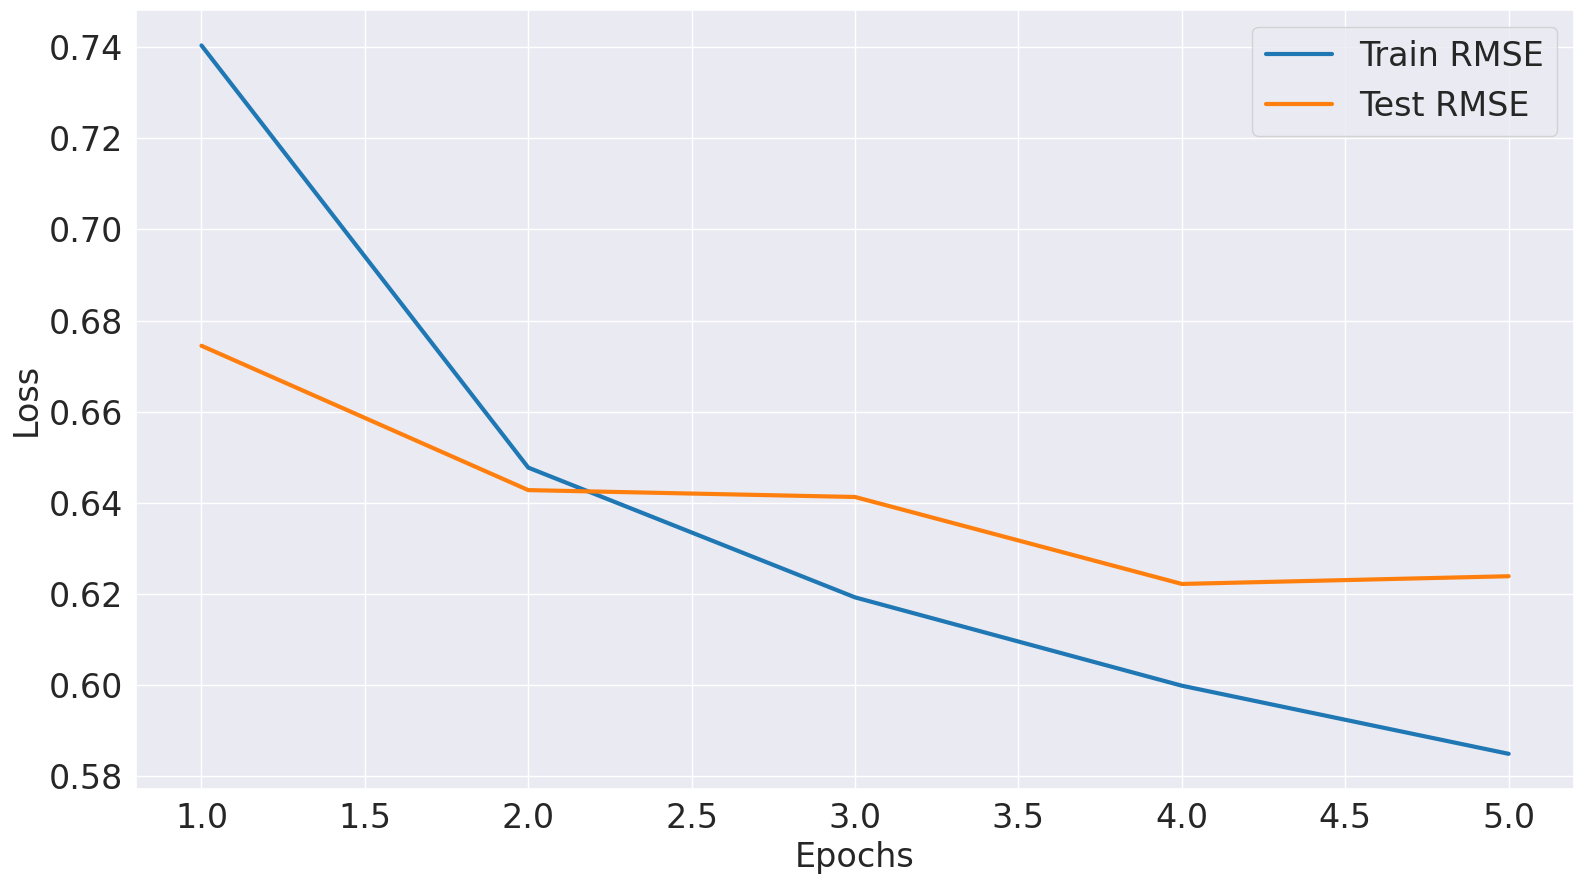

In [5]:
# Data/results directories
result_tag = 'esm_blstm-dms_binding' # specify expression or binding
data_dir = './data/split_processed_dms'
results_dir = './run_results/esm-blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 5
batch_size = 32
max_batch = -1
num_workers = 64
lr = 1e-5
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

dms_train_csv = os.path.join(data_dir, 'mutation_combined_binding_train.csv') # binding
dms_test_csv = os.path.join(data_dir, 'mutation_combined_binding_test.csv') 
trained_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save"

train_dataset = DMSDataset(dms_train_csv)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = DMSDataset(dms_test_csv)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)
load_model_from_trained(model, trained_model_pth, device)

# Run
count_parameters(model)
saved_model_pth = None
from_checkpoint = False
save_as = f"{result_tag}-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, from_checkpoint)

### Running through dataset, again:

This time we will only use the test dataset, and compare the new pretrained model (for 5000 epochs, and best saved) with the esm-only and the older dms trained model. This should give us a better comparison as to how much better the model performs with the newer (and most importantly, additional) data.

In [6]:
evaluation_results = {}

# Data directories
data_dir = './data/split_processed_dms'

# Run setup
batch_size = 32
num_workers = 64
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Create Binding Dataset and DataLoader
torch.manual_seed(0)

older_trained_binding_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save"
newer_trained_binding_best_model_pth = "./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/best_saved_model.pth"
newer_trained_binding_model_pth = "./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/checkpoint_saved_model.pth"

dms_binding_csv = os.path.join(data_dir, 'mutation_combined_binding_test.csv') # binding
binding_dataset = DMSDataset(dms_binding_csv)
binding_data_loader = DataLoader(binding_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# Create Expression Dataset and DataLoader
older_trained_expression_model_pth = "../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save"
newer_trained_expression_best_model_pth = "./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/best_saved_model.pth"
newer_trained_expression_model_pth = "./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/checkpoint_saved_model.pth"

dms_expression_csv = os.path.join(data_dir, 'mutation_combined_expression_test.csv') # expression
expression_dataset = DMSDataset(dms_expression_csv)
expression_data_loader = DataLoader(expression_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Run prior to loading, binding
mse, rmse = run_test_only(model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE Loss: {mse:.4f} | RMSE Loss: {rmse:.4f}')
entry = {
    'Model': 'ESM-Pretrained Binding',
    'Dataset' : "Binding",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['ESM-Pretrained Binding'] = entry

# Run prior to loading, expression
mse, rmse = run_test_only(model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')
entry = {
    'Model': 'ESM-Pretrained Expression',
    'Dataset' : "Expression",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['ESM-Pretrained Expression'] = entry

Evaluation: 100%|| 616/616 [00:17<00:00, 35.49it/s]

Binding Evaluation | MSE Loss: 62.7792 | RMSE Loss: 7.9233



Evaluation: 100%|| 651/651 [00:18<00:00, 35.77it/s]

Expression Evaluation | MSE: 69.9575 | RMSE: 8.3641


In [8]:
# Run after loading, OLDER
load_model_from_trained(model, older_trained_binding_model_pth, device)
mse, rmse = run_test_only(model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE Loss: {mse:.4f} | RMSE Loss: {rmse:.4f}')

entry = {
    'Model': 'Older DMS-Pretrained Binding',
    'Dataset' : "Binding",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Older DMS-Pretrained Binding'] = entry

load_model_from_trained(model, older_trained_expression_model_pth, device)
mse, rmse = run_test_only(model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')

entry = {
    'Model': 'Older DMS-Pretrained Expression',
    'Dataset' : "Expression",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Older DMS-Pretrained Expression'] = entry

Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save


Evaluation: 100%|| 616/616 [00:17<00:00, 35.48it/s]

Binding Evaluation | MSE Loss: 4.3134 | RMSE Loss: 2.0769
Loaded trained model from ../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save



Evaluation: 100%|| 651/651 [00:18<00:00, 35.75it/s]

Expression Evaluation | MSE: 0.9043 | RMSE: 0.9509


In [9]:
# Run after loading, NEWER LAST
load_model_from_trained(model, newer_trained_binding_model_pth, device)
mse, rmse = run_test_only(model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE Loss: {mse:.4f} | RMSE Loss: {rmse:.4f}')

entry = {
    'Model': 'Newer DMS-Pretrained Binding',
    'Dataset' : "Binding",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Newer DMS-Pretrained Binding'] = entry

load_model_from_trained(model, newer_trained_expression_model_pth, device)
mse, rmse = run_test_only(model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')

entry = {
    'Model': 'Newer DMS-Pretrained Expression',
    'Dataset' : "Expression",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Newer DMS-Pretrained Expression'] = entry

Loaded trained model from ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/checkpoint_saved_model.pth


Evaluation: 100%|| 616/616 [00:17<00:00, 35.71it/s]

Binding Evaluation | MSE Loss: 0.0800 | RMSE Loss: 0.2828
Loaded trained model from ./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/checkpoint_saved_model.pth



Evaluation: 100%|| 651/651 [00:18<00:00, 35.78it/s]

Expression Evaluation | MSE: 0.0988 | RMSE: 0.3143


In [10]:
# Run after loading, NEWER BEST
load_model_from_trained(model, newer_trained_binding_best_model_pth, device)
mse, rmse = run_test_only(model, tokenizer, binding_data_loader, device)
print(f'Binding Evaluation | MSE Loss: {mse:.4f} | RMSE Loss: {rmse:.4f}')

entry = {
    'Model': 'Newer Best DMS-Pretrained Binding',
    'Dataset' : "Binding",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Newer Best DMS-Pretrained Binding'] = entry

load_model_from_trained(model, newer_trained_expression_best_model_pth, device)
mse, rmse = run_test_only(model, tokenizer, expression_data_loader, device)
print(f'Expression Evaluation | MSE: {mse:.4f} | RMSE: {rmse:.4f}')

entry = {
    'Model': 'Newer Best DMS-Pretrained Expression',
    'Dataset' : "Expression",
    'MSE': mse,
    'RMSE': rmse
}
evaluation_results['Newer Best DMS-Pretrained Expression'] = entry

Loaded trained model from ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/best_saved_model.pth


Evaluation: 100%|| 616/616 [00:17<00:00, 35.48it/s]

Binding Evaluation | MSE Loss: 0.2504 | RMSE Loss: 0.5004
Loaded trained model from ./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/best_saved_model.pth



Evaluation: 100%|| 651/651 [00:18<00:00, 35.90it/s]

Expression Evaluation | MSE: 0.1785 | RMSE: 0.4226


In [11]:
# Convert the dictionary values to a pandas DataFrame
evaluation_results_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
evaluation_results_df.reset_index(drop=True, inplace=True)
evaluation_results_df.sort_values(by="Dataset")

,Model,Dataset,MSE,RMSE
0,ESM-Pretrained Binding,Binding,62.779248,7.923336
2,Older DMS-Pretrained Binding,Binding,4.313371,2.076866
4,Newer DMS-Pretrained Binding,Binding,0.080002,0.282846
6,Newer Best DMS-Pretrained Binding,Binding,0.250438,0.500437
1,ESM-Pretrained Expression,Expression,69.957532,8.364062
3,Older DMS-Pretrained Expression,Expression,0.904258,0.950925
5,Newer DMS-Pretrained Expression,Expression,0.098812,0.314344
7,Newer Best DMS-Pretrained Expression,Expression,0.178549,0.422550


Let's also add in a comparison as to what the best/last RMSE values were for the model post pretraining on the new model:

In [12]:
def load_model_weight_stats(saved_model_pth, device):
    saved_state = torch.load(saved_model_pth, map_location=device)
    epoch = saved_state['epoch']
    loss = saved_state['loss']
    print(f"Loaded model from {saved_model_pth} at epoch {epoch}, loss {loss}")


device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

newer_trained_binding_best_model_pth = "./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/best_saved_model.pth"
load_model_weight_stats(newer_trained_binding_best_model_pth, device)

newer_trained_binding_model_pth = "./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/checkpoint_saved_model.pth"
load_model_weight_stats(newer_trained_binding_model_pth, device)

newer_trained_expression_best_model_pth = "./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/best_saved_model.pth"
load_model_weight_stats(newer_trained_expression_best_model_pth, device)

newer_trained_expression_model_pth = "./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/checkpoint_saved_model.pth"
load_model_weight_stats(newer_trained_expression_model_pth, device)

Loaded model from ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/best_saved_model.pth at epoch 15, loss 0.6139503895894629
Loaded model from ./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-01_13-11/checkpoint_saved_model.pth at epoch 5000, loss 0.6444656934805582
Loaded model from ./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/best_saved_model.pth at epoch 13, loss 0.5566934834062631
Loaded model from ./run_results/esm-blstm/esm_blstm-dms_expression-2024-08-01_13-10/checkpoint_saved_model.pth at epoch 5000, loss 0.7359751443045619
